In [1]:
!pip install spacy==2.3.5
!pip install scispacy==0.3.0
!pip install eli5

In [26]:
import spacy
import scispacy
import eli5

from pprint import pprint
from tqdm import tqdm
from collections import OrderedDict
import pandas as pd

from spacy import displacy
from scispacy.umls_linking import UmlsEntityLinker

from sklearn.base import BaseEstimator
from typing import Dict, Tuple
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier

# Standard Imports
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Transformers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report
from IPython.display import display, Markdown


# should be 2.3.5 and >=0.3.0
spacy.__version__, scispacy.__version__

('2.3.5', '0.3.0')

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Read in structured data with relevant features (generated and hand labeled data)



In [4]:
# read in hand labeled data
hand_df = pd.read_csv("gdrive/MyDrive/6.871/hand_labeled_mimic_features.csv")

# split labeled data into training, testing sets for hand labeled data

hand_X = hand_df[['check_umls', 'neg_check_umls', "check_med7", "dep_sim"]].copy()
hand_y = hand_df["contradiction?"]

hand_train_X, hand_test_X, hand_train_y, hand_test_y = train_test_split(hand_X, hand_y, test_size=0.3)

In [5]:
# for generated dataset
generated_df = pd.read_csv("gdrive/MyDrive/6.871/generated_features.csv")
print(generated_df)

    Unnamed: 0  neg_check_umls  ...  conflict_type  pair_id
0            0               1  ...            lab        0
1            1               0  ...            lab        1
2            2               0  ...            lab        2
3            3               0  ...   prescription        3
4            4               0  ...   prescription        4
..         ...             ...  ...            ...      ...
68          68               0  ...            lab       68
69          69               0  ...            lab       69
70          70               0  ...      diagnosis       70
71          71               0  ...      diagnosis       71
72          72               0  ...      diagnosis       72

[73 rows x 10 columns]


In [6]:
# fill Na with 0
generated_df = generated_df.fillna(0)

generated_X = generated_df.drop(["sentence_1", "sentence_2", "Unnamed: 0", 'pair_id', 'conflict_type', "contradiction?"], axis=1)
generated_y = generated_df["contradiction?"]

# split into train and test sets
gen_train_X, gen_test_X, gen_train_y, gen_test_y = train_test_split(generated_X, generated_y, test_size=0.3)

gen_train_X = gen_train_X.reset_index(drop=True)
gen_test_X = gen_test_X.reset_index(drop=True)
gen_train_y = gen_train_y.reset_index(drop=True)
gen_test_y = gen_test_y.reset_index(drop=True)

gen_train_X = pd.concat((gen_train_X, hand_train_X), axis=0)
gen_test_X = pd.concat((gen_test_X, hand_test_X), axis=0)
gen_train_y = pd.concat((gen_train_y, hand_train_y), axis=0)
gen_test_y = pd.concat((gen_test_y, hand_test_y), axis=0)

#print(generated_X)
#print(generated_y)

print(gen_train_X)
print(gen_test_X)
print(gen_train_y)
print(gen_test_y)

    neg_check_umls  check_umls  check_med7   dep_sim
0                1           1           0  0.644780
1                0           1           1  0.606756
2                0           1           0  0.720361
3                0           1           0  0.931884
4                0           1           0  1.000000
..             ...         ...         ...       ...
17               0           1           0  0.614619
19               0           1           1  0.793324
35               0           1           0  0.718066
22               0           1           1  0.793324
20               0           0           0  0.656870

[88 rows x 4 columns]
    neg_check_umls  check_umls  check_med7   dep_sim
0                0           1           0  0.774842
1                0           1           1  0.569560
2                0           1           0  0.700741
3                0           1           0  0.388793
4                0           1           0  0.562344
5                0     

Establish rules to explore as relevant features

In [7]:
# RULES:
# check_umls: if they do not share a concept, return 1 (no contradiction)
# neg_check_umls: if number of neg tokens is equal, return 0 (no contradiction); otherwise, return 1 (contradiction)
# check_med7: if not talking about same DRUG -> return 0 (no contradiction); if same DRUG but different other info -> return 1 (contradiction)
# dep_sim: if similarity < 0.5 (contradiction)


rules = {"check_umls": [
                ("=", 1, 0.0)
              ], 
        "neg_check_umls": [
                ("=", 1, 1.0)
              ],
         "check_med7": [
                ("=", 1, 1.0)
              ],
         "dep_sim": [
                ("<", 0.5, 1.0)
              ]
        }

Hybrid rule-based learning with auto learned rules

In [8]:
class RuleAugmentedEstimator(BaseEstimator):
  """
  Augments sklearn estimators with deterministic rule-based logic.
  """

  def __init__(self, base_model: BaseEstimator, rules: Dict, **base_params):
      """
      Initializes the rule-augmented estimator by supplying underlying sklearn estimator
      and hard-coded rules.

      Args:
        base_model: underlying sklearn estimator.
          Must implement fit and predict method.
        rules: hard coded rules in format of dictionary,
          with keys being the pandas dataframe column name, 
          and values being a tuple in the following form: 
          (comparison operator, value, return value)

          Acceptable comparison operators are: 
          "=", "<", ">", "<=", ">="

          Example:
                
                {"House Type": [
                    ("=", "Penthouse", 1.0),
                    ("=", "Shack", 0.0)
                  ],
                  "House Price": [
                      ("<", 1000.0, 0.0),
                      (">=", 500000.0, 1.0)
                ]}
        **base_params: Optional keyword arguments which will be passed on
            to the base_model.

      """
      self.rules = rules
      self.base_model = base_model
      self.base_model.set_params(**base_params)
      self.outcome_range = [0,1]

  def __repr__(self):
      return "Rule Augmented Estimator:\n\n\t Base Model: {}\n\t Rules: {}".format(self.base_model, self.rules)

  def __str__(self):
      return self.__str__

  def _get_base_model_data(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
      """
      Filters the training data for data points not affected by the rules.
      """
      train_x = X

      for category, rules in self.rules.items():

          if category not in train_x.columns.values: continue

          for rule in rules:

              if rule[0] == "=":
                  train_x = train_x.loc[train_x[category] != rule[1]]

              elif rule[0] == "<":
                  train_x = train_x.loc[train_x[category] >= rule[1]]

              elif rule[0] == ">":
                  train_x = train_x.loc[train_x[category] <= rule[1]]

              elif rule[0] == "<=":
                  train_x = train_x.loc[train_x[category] > rule[1]]

              elif rule[0] == ">=":
                  train_x = train_x.loc[train_x[category] < rule[1]]

              else:
                  print("Invalid rule detected: {}".format(rule))
              
      indices = train_x.index.values
      train_y = y.iloc[indices]
      
      train_x = train_x.reset_index(drop=True)
      train_y = train_y.reset_index(drop=True)
      
      return train_x, train_y   

  def fit(self, X: pd.DataFrame, y: pd.Series, **kwargs):
      """Fits the estimator to the data.
      
      Fits the estimator to the data, only training the underlying estimator
      on data which isn't affected by the hard-coded rules.
      
      Args:
          X: The training feature data.
          y: The training label data.
          **kwargs: Optional keyword arguments passed to the underlying
          estimator's fit function.
              
      """
      train_x, train_y = self._get_base_model_data(X, y)
      self.base_model.fit(train_x, train_y, **kwargs)

  def predict(self, X: pd.DataFrame) -> np.array:
      """Gets predictions for the provided feature data.
      
      The predicitons are evaluated using the provided rules wherever possible
      otherwise the underlying estimator is used.
      
      Args:
          X: The feature data to evaluate predictions for.
      
      Returns:
          np.array: Evaluated predictions.
      """
      
      p_X = X.copy()
      p_X['prediction'] = np.nan

      for category, rules in self.rules.items():

          if category not in p_X.columns.values: continue

          for rule in rules:

              if rule[0] == "=":
                  p_X.loc[p_X[category] == rule[1], 'prediction'] = rule[2]

              elif rule[0] == "<":
                  p_X.loc[p_X[category] < rule[1], 'prediction'] = rule[2]

              elif rule[0] == ">":
                  p_X.loc[p_X[category] > rule[1], 'prediction'] = rule[2]

              elif rule[0] == "<=":
                  p_X.loc[p_X[category] <= rule[1], 'prediction'] = rule[2]

              elif rule[0] == ">=":
                  p_X.loc[p_X[category] >= rule[1], 'prediction'] = rule[2]

              else:
                  print("Invalid rule detected: {}".format(rule))

      if len(p_X.loc[p_X['prediction'].isna()].index != 0):

          base_X = p_X.loc[p_X['prediction'].isna()].copy()
          base_X.drop('prediction', axis=1, inplace=True)
          p_X.loc[p_X['prediction'].isna(), 'prediction'] = self.base_model.predict(base_X)

      return p_X['prediction'].values
    
  def get_params(self, deep: bool = True) -> Dict:
      """Return the model's and base model's parameters.
      Args:
          deep: Whether to recursively return the base model's parameters.
      Returns
          Dict: The model's parameters.
      """
      
      params = {'base_model': self.base_model,
                'outcome_range': self.outcome_range,
                'rules': self.rules
                }

      params.update(self.base_model.get_params(deep=deep))
      return params
    
  def set_params(self, **params):
      """Sets parameters for the model and base model.
      Args:
          **params: Optional keyword arguments.
      """
                
      parameters = params
      param_keys = parameters.keys()
      
      if 'base_model' in param_keys:
          value = parameters.pop('base_model')
          self.base_model = value

In [9]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show();

Set up training for generated dataset

In [10]:
# fit the hybrid model with relevant features after hyperparameter tuning
gbc = GradientBoostingClassifier(n_estimators=100, verbose=1)
hybrid_model = RuleAugmentedEstimator(gbc, rules)

hybrid_model.fit(gen_train_X, gen_train_y)
predictions = hybrid_model.predict(gen_test_X)

      Iter       Train Loss   Remaining Time 
         1           0.9351            0.14s
         2           0.7981            0.13s
         3           0.6909            0.12s
         4           0.6035            0.12s
         5           0.5306            0.11s
         6           0.4686            0.11s
         7           0.4155            0.11s
         8           0.3694            0.11s
         9           0.3292            0.11s
        10           0.2940            0.10s
        20           0.1007            0.06s
        30           0.0362            0.05s
        40           0.0132            0.04s
        50           0.0048            0.03s
        60           0.0018            0.02s
        70           0.0007            0.02s
        80           0.0005            0.01s
        90           0.0005            0.01s
       100           0.0005            0.00s


Recall:  0.5454545454545454
Accuracy:  0.5641025641025641
Precision:  0.3333333333333333
F1:  0.41379310344827586


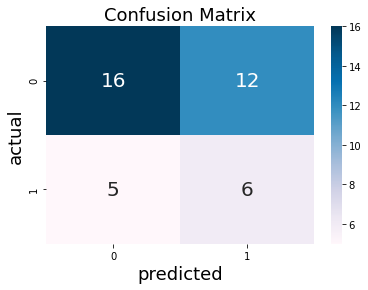

In [11]:
# hybrid
evaluation(gen_test_y, predictions)

In [12]:
# hybrid model features
num_feats = list(gen_train_X.columns)
feat_imp = eli5.explain_weights_df(gbc, top=10, feature_names=num_feats)
print(feat_imp)

          feature  weight       std
0         dep_sim     1.0  0.433013
1      check_med7     0.0  0.000000
2      check_umls     0.0  0.000000
3  neg_check_umls     0.0  0.000000


Rule based model only

In [13]:
class RuleBasedEstimator(BaseEstimator):
  """
  Uses deterministic rule-based logic.
  """

  def __init__(self, base_model: BaseEstimator, rules: Dict, **base_params):
      """
      Initializes the rule-based estimator by supplying hard-coded rules.

      Args:
        base_model: underlying sklearn estimator.
          Must implement fit and predict method.
        rules: hard coded rules in format of dictionary,
          with keys being the pandas dataframe column name, 
          and values being a tuple in the following form: 
          (comparison operator, value, return value)

          Acceptable comparison operators are: 
          "=", "<", ">", "<=", ">="

          Example:
                
                {"House Type": [
                    ("=", "Penthouse", 1.0),
                    ("=", "Shack", 0.0)
                  ],
                  "House Price": [
                      ("<", 1000.0, 0.0),
                      (">=", 500000.0, 1.0)
                ]}
        **base_params: Optional keyword arguments which will be passed on
            to the base_model.

      """
      self.rules = rules
      self.base_model = base_model
      self.base_model.set_params(**base_params)

  def __repr__(self):
      return "Rule Augmented Estimator:\n\n\t Base Model: {}\n\t Rules: {}".format(self.base_model, self.rules)

  def __str__(self):
      return self.__str__
  

  def fit(self, X: pd.DataFrame, y: pd.Series, **kwargs):
      """Fits the estimator to the data.
      
      Fits the estimator to the data, only training the underlying estimator
      on data which isn't affected by the hard-coded rules.
      
      Args:
          X: The training feature data.
          y: The training label data.
          **kwargs: Optional keyword arguments passed to the underlying
          estimator's fit function.
              
      """
      self.base_model.fit(X, y, **kwargs)

  def predict(self, X: pd.DataFrame) -> np.array:
      """Gets predictions for the provided feature data.
      
      The predicitons are evaluated using the provided rules wherever possible
      otherwise the underlying estimator is used.
      
      Args:
          X: The feature data to evaluate predictions for.
      
      Returns:
          np.array: Evaluated predictions.
      """
      
      p_X = X.copy()
      p_X['prediction'] = np.nan

      for category, rules in self.rules.items():

          if category not in p_X.columns.values: continue

          for rule in rules:

              if rule[0] == "=":
                  p_X.loc[p_X[category] == rule[1], 'prediction'] = rule[2]

              elif rule[0] == "<":
                  p_X.loc[p_X[category] < rule[1], 'prediction'] = rule[2]

              elif rule[0] == ">":
                  p_X.loc[p_X[category] > rule[1], 'prediction'] = rule[2]

              elif rule[0] == "<=":
                  p_X.loc[p_X[category] <= rule[1], 'prediction'] = rule[2]

              elif rule[0] == ">=":
                  p_X.loc[p_X[category] >= rule[1], 'prediction'] = rule[2]

              else:
                  print("Invalid rule detected: {}".format(rule))

      # check if any predictions missing (relegate to base_model)
      if len(p_X.loc[p_X['prediction'].isna()].index != 0):

          base_X = p_X.loc[p_X['prediction'].isna()].copy()
          base_X.drop('prediction', axis=1, inplace=True)
          p_X.loc[p_X['prediction'].isna(), 'prediction'] = self.base_model.predict(base_X)

      return p_X['prediction'].values
    

  def get_params(self, deep: bool = True) -> Dict:
      """Return the model's and base model's parameters.
      Args:
          deep: Whether to recursively return the base model's parameters.
      Returns
          Dict: The model's parameters.
      """
      
      params = {'base_model': self.base_model,
                'rules': self.rules
                }

      params.update(self.base_model.get_params(deep=deep))
      return params
  

  def set_params(self, **params):
      """Sets parameters for the model and base model.
      Args:
          **params: Optional keyword arguments.
      """
                
      parameters = params
      param_keys = parameters.keys()
      
      if 'base_model' in param_keys:
          value = parameters.pop('base_model')
          self.base_model = value
          
      if 'rules' in param_keys:
          value = parameters.pop('rules')
          self.rules = value
      
      self.base_model.set_params(**parameters)

In [14]:
rules = {"check_umls": [
                ("=", 1, 0.0),
                ("=", 0, 1.0)
              ], 
        "neg_check_umls": [
                ("=", 1, 1.0),
                ("=", 0, 0.0)
              ],
         "check_med7": [
                ("=", 1, 1.0),
                ("=", 0, 0.0)
              ],
         "dep_sim": [
                ("<", 0.5, 1.0),
                (">=", 0.5, 0.0)
              ]
        }

In [15]:
# fit the rule based model with relevant features
gbc = GradientBoostingClassifier(n_estimators=100, verbose=1)
rule_model = RuleBasedEstimator(gbc, rules)
rule_model.fit(gen_train_X, gen_train_y)
predictions = rule_model.predict(gen_test_X)

      Iter       Train Loss   Remaining Time 
         1           1.0624            0.24s
         2           1.0302            0.23s
         3           0.9977            0.25s
         4           0.9738            0.24s
         5           0.9516            0.32s
         6           0.9331            0.29s
         7           0.8934            0.28s
         8           0.8747            0.26s
         9           0.8443            0.24s
        10           0.8180            0.23s
        20           0.6803            0.13s
        30           0.6075            0.09s
        40           0.5111            0.07s
        50           0.4433            0.05s
        60           0.3943            0.04s
        70           0.3637            0.03s
        80           0.3361            0.02s
        90           0.3135            0.01s
       100           0.2936            0.00s


Recall:  0.36363636363636365
Accuracy:  0.6666666666666666
Precision:  0.4
F1:  0.380952380952381


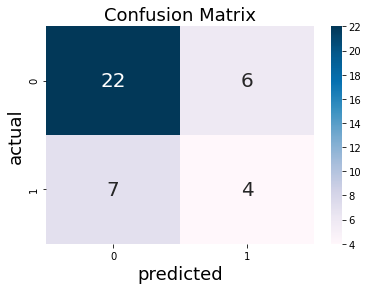

In [16]:
# rule only
evaluation(gen_test_y, predictions)

In [17]:
# rule model features
num_feats = list(gen_train_X.columns)
feat_imp = eli5.explain_weights_df(gbc, top=10, feature_names=num_feats)
print(feat_imp)

          feature    weight       std
0         dep_sim  0.913342  0.077582
1      check_med7  0.054628  0.066035
2  neg_check_umls  0.029258  0.050562
3      check_umls  0.002772  0.007961


Decision tree algorithm (gradient boosting classifier): auto learned rules only

In [18]:
gbc = GradientBoostingClassifier(n_estimators=100, verbose=1)
gbc.fit(gen_train_X, gen_train_y)
predictions = gbc.predict(gen_test_X)

      Iter       Train Loss   Remaining Time 
         1           1.0624            0.28s
         2           1.0302            0.34s
         3           0.9977            0.27s
         4           0.9738            0.23s
         5           0.9516            0.21s
         6           0.9331            0.20s
         7           0.8934            0.18s
         8           0.8747            0.17s
         9           0.8443            0.16s
        10           0.8180            0.15s
        20           0.6803            0.09s
        30           0.6075            0.07s
        40           0.5111            0.05s
        50           0.4433            0.04s
        60           0.3943            0.03s
        70           0.3637            0.02s
        80           0.3361            0.01s
        90           0.3135            0.01s
       100           0.2936            0.00s


Recall:  0.18181818181818182
Accuracy:  0.5897435897435898
Precision:  0.2222222222222222
F1:  0.19999999999999998


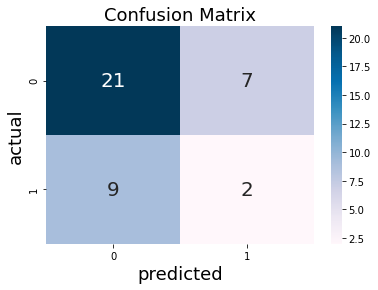

In [19]:
# GBC only
evaluation(gen_test_y, predictions)

In [20]:
# gbc model features
num_feats = list(gen_train_X.columns)
feat_imp = eli5.explain_weights_df(gbc, top=10, feature_names=num_feats)
print(feat_imp)

          feature    weight       std
0         dep_sim  0.912282  0.078543
1      check_med7  0.055738  0.067712
2  neg_check_umls  0.029207  0.049579
3      check_umls  0.002772  0.007961


MIMIC qualitative exploration

In [21]:
# for generated dataset
mimic_df = pd.read_csv("gdrive/MyDrive/6.871/mimic_features.csv")
print(mimic_df)

     Unnamed: 0  neg_check_umls  ...         conflict_type  pair_id
0             0               0  ...         ['diagnosis']        0
1             1               0  ...         ['diagnosis']        1
2             2               0  ...         ['diagnosis']        2
3             3               0  ...         ['diagnosis']        3
4             4               0  ...         ['diagnosis']        4
..          ...             ...  ...                   ...      ...
836         836               0  ...              ['test']      156
837         837               0  ...              ['test']      157
838         838               0  ...  ['diagnosis', 'med']      158
839         839               0  ...  ['diagnosis', 'med']      159
840         840               0  ...  ['diagnosis', 'med']      160

[841 rows x 10 columns]


In [22]:
mimic_X = mimic_df[['check_umls', 'neg_check_umls', "check_med7", "dep_sim"]].copy()
print(mimic_X)

     check_umls  neg_check_umls  check_med7   dep_sim
0             1               0           0  0.761119
1             1               0           0  0.268047
2             1               0           0  0.588540
3             1               0           0  0.758409
4             1               0           0  0.808922
..          ...             ...         ...       ...
836           1               0           0  0.327957
837           1               0           0  0.868670
838           1               0           0  0.643665
839           1               0           0  0.658082
840           1               0           0  0.941207

[841 rows x 4 columns]


In [23]:
# gbc only
gbc = GradientBoostingClassifier(n_estimators=100, verbose=1)
gbc.fit(gen_train_X, gen_train_y)
predictions = gbc.predict(mimic_X)

      Iter       Train Loss   Remaining Time 
         1           1.0624            0.13s
         2           1.0302            0.14s
         3           0.9977            0.15s
         4           0.9738            0.14s
         5           0.9516            0.12s
         6           0.9331            0.12s
         7           0.8934            0.11s
         8           0.8747            0.11s
         9           0.8443            0.11s
        10           0.8180            0.10s
        20           0.6803            0.07s
        30           0.6075            0.05s
        40           0.5111            0.04s
        50           0.4433            0.03s
        60           0.3943            0.03s
        70           0.3637            0.02s
        80           0.3361            0.01s
        90           0.3135            0.01s
       100           0.2936            0.00s


In [29]:
# positive examples
positive_indices = np.where(predictions == 1)

positive_examples_df = pd.DataFrame()
for positive_index in tqdm(positive_indices[0]):
  pos_example = mimic_df.iloc[positive_index]
  positive_examples_df = pd.concat((positive_examples_df, pos_example), axis=1)

positive_examples_df_transposed = positive_examples_df.T 
print(positive_examples_df_transposed)
positive_examples_df_transposed.to_csv("positive_examples_mimic_eval_generated.csv")

100%|██████████| 163/163 [00:00<00:00, 745.22it/s]

    Unnamed: 0 neg_check_umls check_umls  ... hadm_id         conflict_type pair_id
4            4              0          1  ...  162197         ['diagnosis']       4
6            6              1          1  ...  162197         ['diagnosis']       6
15          15              1          1  ...  162197         ['diagnosis']      15
18          18              1          1  ...  162197         ['diagnosis']      18
23          23              0          1  ...  162197         ['diagnosis']      23
..         ...            ...        ...  ...     ...                   ...     ...
817        817              0          1  ...  120799               ['med']     137
824        824              0          1  ...  120799  ['diagnosis', 'med']     144
826        826              0          1  ...  120799                    []     146
834        834              1          1  ...  120799              ['test']     154
840        840              0          1  ...  120799  ['diagnosis', 'med'] 

In [30]:
# negative examples
negative_indices = np.where(predictions == 0)

negative_examples_df = pd.DataFrame()
for negative_index in tqdm(negative_indices[0]):
  neg_example = mimic_df.iloc[negative_index]
  negative_examples_df = pd.concat((negative_examples_df, neg_example), axis=1)

negative_examples_df_transposed = negative_examples_df.T
print(negative_examples_df_transposed)
negative_examples_df_transposed.to_csv("negative_examples_mimic_eval_generated.csv")



100%|██████████| 678/678 [00:00<00:00, 682.98it/s]


    Unnamed: 0 neg_check_umls check_umls  ... hadm_id         conflict_type pair_id
0            0              0          1  ...  162197         ['diagnosis']       0
1            1              0          1  ...  162197         ['diagnosis']       1
2            2              0          1  ...  162197         ['diagnosis']       2
3            3              0          1  ...  162197         ['diagnosis']       3
5            5              0          1  ...  162197         ['diagnosis']       5
..         ...            ...        ...  ...     ...                   ...     ...
835        835              1          1  ...  120799              ['test']     155
836        836              0          1  ...  120799              ['test']     156
837        837              0          1  ...  120799              ['test']     157
838        838              0          1  ...  120799  ['diagnosis', 'med']     158
839        839              0          1  ...  120799  ['diagnosis', 'med'] 